In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
pkg = mp.open_package('index:sandiegodata.org-planning')
pkg

In [8]:
df = pkg.resource('hpi').read_csv()
df.head().T

,0,1,2,3,4
geoid,14000US06001400100,14000US06001400200,14000US06001400300,14000US06001400400,14000US06001400500
pop2010,2937,1974,4865,3703,3517
pct2010gq,0.1,3.5,0.8,0.9,3.6
city,Oakland,Oakland,Oakland,Oakland,Oakland
zip,94704,94618,94618,94609,94609
county_fips,6001,6001,6001,6001,6001
county_name,Alameda,Alameda,Alameda,Alameda,Alameda
urbantype,urban_area,urban_area,urban_area,urban_area,urban_area
hpi2score,1.18203,1.32587,0.925666,1.1176,0.562799
hpi2_pctile_pos,99.1146,99.7049,95.9322,98.5371,83.3184


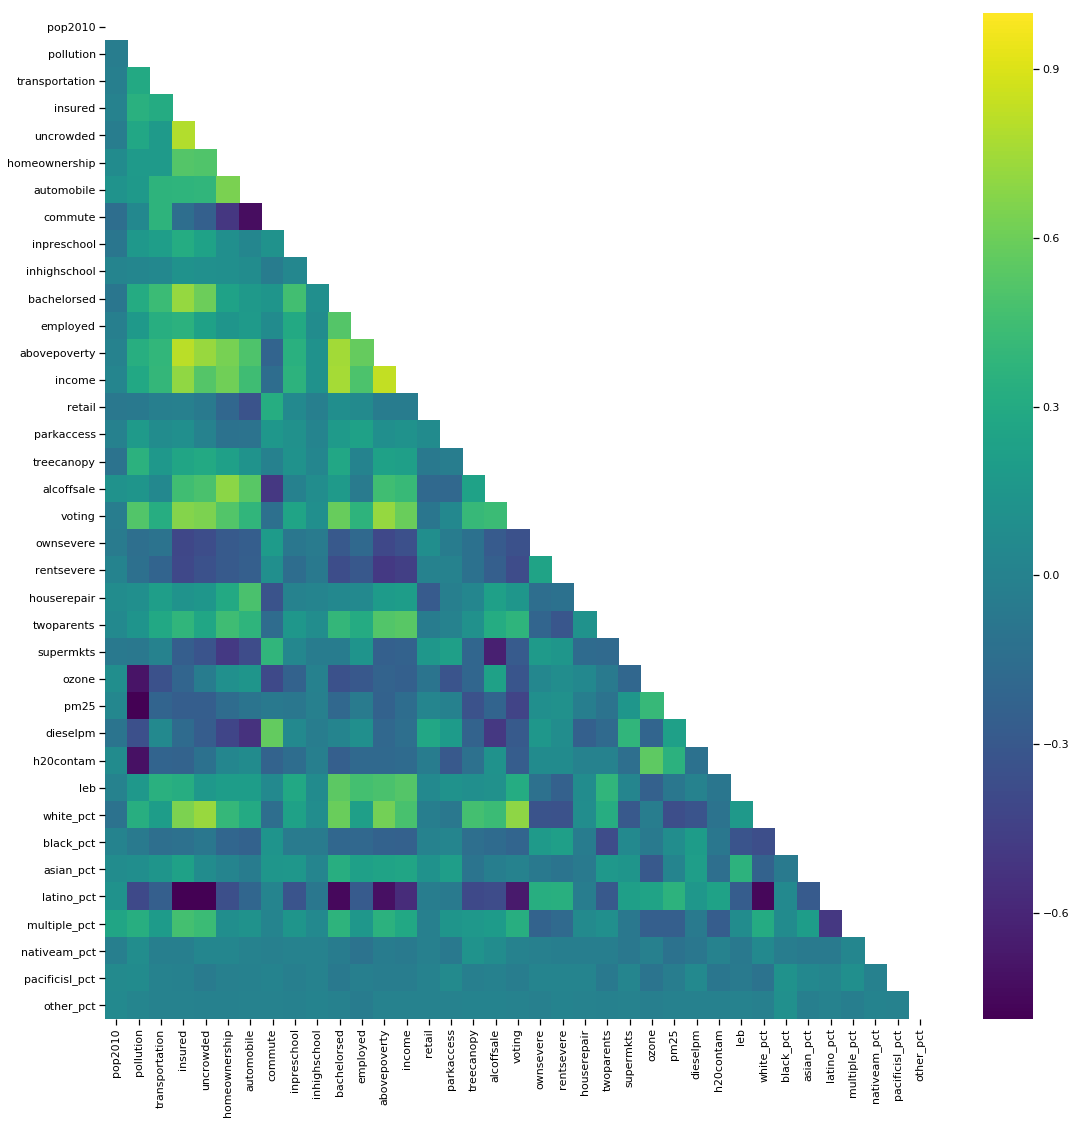

In [4]:
cor_cols = ['pop2010', 'pollution', 'transportation', 
 'insured', 'uncrowded', 'homeownership', 'automobile', 'commute', 'inpreschool', 'inhighschool', 
 'bachelorsed', 'employed', 'abovepoverty', 'income', 'retail', 'parkaccess', 'treecanopy', 'alcoffsale',
 'voting', 'ownsevere', 'rentsevere', 'houserepair', 'twoparents', 'supermkts', 'ozone', 'pm25', 'dieselpm', 
 'h20contam', 'leb', 'white_pct', 'black_pct', 'asian_pct', 'latino_pct', 'multiple_pct', 'nativeam_pct',
 'pacificisl_pct', 'other_pct']

cm = df[cor_cols].corr()

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(.5*len(cor_cols),.5*len(cor_cols)))
sns.heatmap(cm, mask=mask, cmap = 'viridis')  


In [30]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [5]:
#cm.stack().reset_index().drop_duplicates()

def top_corr(df):
    """Report on the correlations between every pair of columns. """
    cm = df.corr()
    t = cm.stack().reset_index()

    t['col1'] = t.apply(lambda r: sorted([r.level_0, r.level_1])[0], axis=1)
    t['col2'] = t.apply(lambda r: sorted([r.level_0, r.level_1])[1], axis=1)
    t = t[['col1','col2',0]]
    t.columns = ['col1','col2','cor']
    t = t.drop_duplicates()
    t = t[t.cor < 1.0]
    t = t.sort_values('cor',ascending=False)
    return t
    
t = top_corr(df[cor_cols])
t = t[ (t.cor > .5) | ( t.cor < -.5) ]

high_cor_cols = set( list(t.col1) + list(t.col2))
high_cor_cols

{'abovepoverty',
 'alcoffsale',
 'automobile',
 'bachelorsed',
 'commute',
 'dieselpm',
 'employed',
 'h20contam',
 'homeownership',
 'income',
 'insured',
 'latino_pct',
 'leb',
 'ozone',
 'pm25',
 'pollution',
 'supermkts',
 'twoparents',
 'uncrowded',
 'voting',
 'white_pct'}

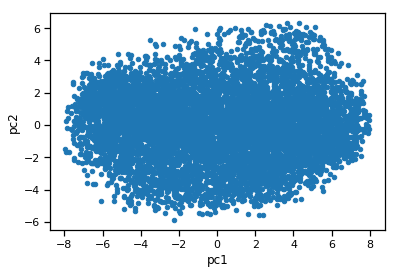

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pctile_cols = [c for c in df.columns if 'pctile' in c]

x = df[pctile_cols].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
x = np.nan_to_num(x)

y = df['hpi2score'].values

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

principalDf.plot.scatter(x='pc1',y='pc2')

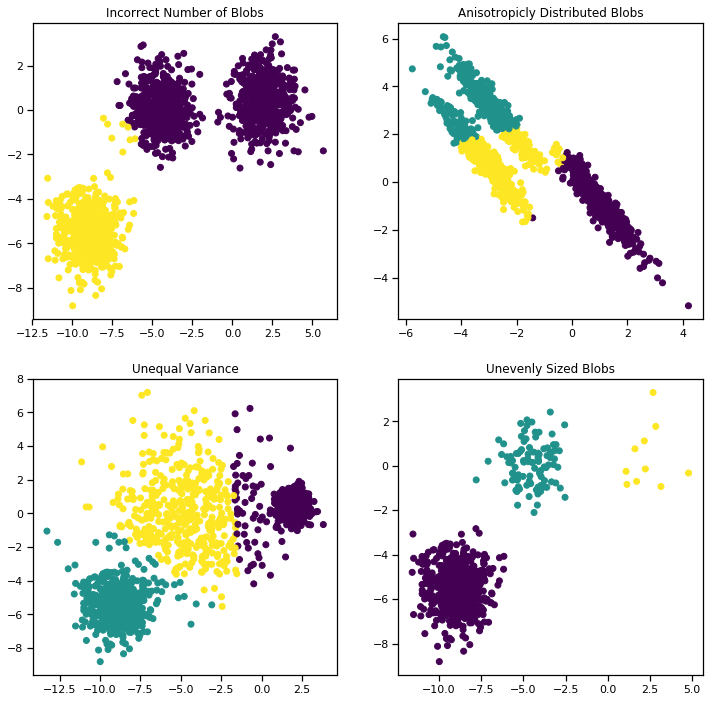

In [31]:

# Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

In [39]:
y

array([1, 1, 0, ..., 2, 2, 2])